# Task 1 : Observation Model Derivation

## Feedback Model - with biases

The state vector $x$ with gyroscope and accelrometer bias is defined as

$x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, b_{ax}, b_{ay}, b_{az}, b_{gx}, b_{gy}, b_{gz}]$

The measeurement vector $z$ is

$z = [L, \lambda, h, v_{N}, v_{E}, v_{D}]$

Then the resulting observation model is

$ z = Cx $

with $$C = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$$

## Feedforward Model - with error states

The state vector $x$ with error states is defined as

$x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, e_{L}, e_{\lambda}, e_{h}]$

The measeurement vector $z$ is

$z = [e_{L}, e_{\lambda}, e_{h}]$

Then the resulting observation model is

$ z = Cx $

with $C = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}$

The implementation of the observation model is code is straightforward - just slice the state vector using the position and velcity indexes. This way we dont need to implement two different C matrices for feedback and feedforward model.

```python
p = x[:3]
v = x[6:9]
```

# Propagation Model Implementation

The propagation model is almost same for both the feedback and feedforward model, the only difference is that in the feedback model implementation the biases are subtacted from the corresponding gyroscope and accelerometer values before propagating them. The **propagation_model()** implements the propagation model, taking as inputs the previous state `X_prev`, the current angular velocity `w_b`, specific forces `f_b` and timestep `dt` and outputs the updated state vector `X_curr`

1. Extract previous states from the state vector - $x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, b_{ax}, b_{ay}, b_{az}, b_{gx}, b_{gy}, b_{gz}]$ 

    ```python
    # extract prev states
    L,l,h = X_prev[:3]
    q = X_prev[3:6]
    v_n = X_prev[6:9]
    v_N,v_E,v_D = v_n
    ```

2. For feedback model subtract biases from the angular velocity and specific force vectors. Otherwise for feedforward model , use the same inputs.

    ```python
    w_i_b = w_i_b - b_g
    f_b = f_b - b_a
    ```

3. **Attitude Update**: Update the orientation euler angles using the given equations. Two crucial points to be noted: 
    a. The angles are in degrees, so they need to be converted  to radians wherever necesary.
    b. Angles need to be wrapped between 0-360 deg.

    ```python
    ###### ATTITUDE UPDATE
    w_e = earth.RATE*np.array([0,0,1])
    omega_i_e = skew(w_e)

    R_N,R_E,R_P = earth.principal_radii(L,h)

    w_e_n = np.zeros(3)
    w_e_n[0] = v_E / (R_E + h)
    w_e_n[1] = -v_N / (R_N + h)
    w_e_n[2] = -v_E * np.tan(np.deg2rad(L)) / (R_E + h)

    omega_e_n = skew(w_e_n)
    omega_i_b = skew(w_i_b)

    R_prev = Rotation.from_euler('xyz',q,degrees=True).as_matrix()

    R_curr = R_prev @ (np.eye(3) + omega_i_b * dt) - (omega_i_e + omega_e_n) @ R_prev * dt

    q_curr = Rotation.from_matrix(R_curr).as_euler('xyz',degrees=True)
    q_curr = wrap_to_360(q_curr)
    ```

4. **Velocity Update**: velocities updates based on the given euqations.

    ```python
    ###### VELOCITY UPDATE
    f_n = 0.5 * (R_prev + R_curr) @ f_b
    g_n = earth.gravity_n(L,h) 
    v_n_curr = v_n + dt * (f_n + g_n - (omega_e_n + 2*omega_i_e) @ v_n)
    ```

5. **Position Update**: similarly positions are updated using the given equations

    ```python
    ###### POSITION UPDATE
    v_N_curr,v_E_curr,v_D_curr = v_n_curr

    h_curr = h - dt/2 * (v_D + v_D_curr)

    L_curr_rad = np.deg2rad(L) + dt/2 * (v_N/(R_N + h) + v_N_curr/(R_N + h_curr))
    L_curr = np.rad2deg(L_curr_rad)

    R_N_curr,R_E_curr,R_P_curr = earth.principal_radii(L_curr,h_curr)
    l_curr_rad = np.deg2rad(l) + dt/2 * (v_E/((R_E + h)*np.cos(np.deg2rad(L))) + v_E_curr/((R_E_curr + h_curr)*np.cos(np.deg2rad(L_curr))))
    l_curr = np.rad2deg(l_curr_rad)
    ```

6. An updated state vector is constructed using the updated position, orientation and velcoity values. Append the biases or the error states according to the model type - feedforward or feedback

# Task 2: Nonlinear Error State implementation - Feedforward model

The **ins_gnss_ff.py** script implements the feedforward model including the error states. The state vector includes the postion, orientation, velocity, error in longitude, error in latitude and error in height. The function **ins_gnss_ff()** initializes the UKF, iterates over the trajectory data and provides the estimates. For each data instance in the trajectory_data.csv file, the UKF performs the following steps:

1. Prediction step - predict(): the UKF generates sigma points using the previous mean state (X_prev) passes them through the propagaion model and calculates the estimated mean (X_est) and covariance (P_est) based on the weights of the sigma points (W_m, W_c). The values alpha = 1, beta = 2 and kappa = 1 have been used to generate sigma points.

2. The measurements in this case are the errors and not the GNSS values. The error states are calculated as the error between the estimated position (the postion obtained after the predict step of the UKF) and the GNSS position measurement. The haversine formula is used to calculate the dist between the estimated longitude, latitude and GNSS postion measurement. The error in height is just the difference between the estimated and measured values. The python code below shows how the error calculations are implemented.

    ```python
    # calc error
    p_est = X_est[:3]
    err = np.zeros(N_OBS)
    dist = haversine(p_est[0:2],p_m[0:2],unit=Unit.DEGREES)
    err[0] = dist
    err[1] = dist
    err[2] = p_est[2] - p_m[2]
    ```

3. Update step - update(): The error calculated above along with the predicted states and covariance are given to the update step. Sigma points are again generated based on the predicted states which are then passed passed through the observation model to extract the estimated measurements. The observation model used is derived in task 1. The error measurements (Z), obtained in the previous step, are then used to update the estimates by calculating the innovation matatrix (S) and the kalman gain (K).

## Tuning Process and Measurement Covariances

Initially the process covariance was set to be Q = 1e-3*np.eye(N_STATE). However, the UKF threw an error saying the covariance matrix is not positive definite after three iterations. Choosing reasonable resolution values for position (longitude and latitude) - 1 deg, height - 10 meters, orientation - 1 deg, velocity - 1 m/s^2 and 1 deg for posotion error and 10 m for height error and then scaling them; resulted in improved performance. Similar approach was used to tune the measurement covariance R with resolution values for position (longitude and latitude) being 1 deg and height being 100 m and a scaling factor of 1e-3. 

Initally the the UKF was only able to process the first ~1000 entries in the dataset and failed to produce any valid estimates. This happened because the state covariance matrix P became negative definite and the cholesky decomposition falied to calculate its square root. I started increasing the covariance values just for the error states and I observed that the UKF was able to process more data. To succesfully compute estimates for all entries in the dataset, covariance values for error states had to be set to extremely high values - of the order **1e20**. The final covariances used are

```python     
Q = np.diag([1,1,100,1,1,1,1,1,1,1e20,1e20,1e20])
R = 1e-3*np.diag([1,1,100])
``` 

# Task 3: Nonlinear Full State implementation - Feedback Model

The **ins_gnss_fb.py** script implements the feedback model on the full state of the system. The state vector includes the postion, orientation, velocity, IMU gyroscope and acceleration biases. The propagation model is the same but with a difference that the biases are subtracted from the input angular velocities and accelerations. The predict and update step of the UKF remain the same with the measurements being the actual GNSS measurements. The function **ins_gnss_fb()** initializes the UKF, iterates over the trajectory data and provides the estimates. The feedback model implementation is similar to implementing a traditional UKF. The steps are explained breifly below:

1. The predict() method of the UKF generates sigma points based on the previous mean state (X_prev), passes them through the propagaion model and calculates the estimated mean (X_est) and covariance (P_est) based on the weights of the sigma points (W_m,W_c). The values alpha = 1, beta = 2 and kappa = 1 have been used to generate sigma points.

2. The GNSS measurements (Z) are passed to the update() method along with the estimated mean and covariance. Sigma points are generated again based on the estimated mean state and covariance. Using the observation model, derived in task 1, the estimated measurements are retreived from each sigma point. By calculating the innovation matrix (S) and kalman gain (K), the state estimates and covariance are updated. 

## Tuning Process and Measurement Covariances

To tune the process covariance, reasonable resolution values were chosen for position (longitude and latitude) - 1 deg, height - 10 meters, orientation - 1 deg, velocity - 1 m/s^2 and 1e-3 deg for biases. The measurement covariance was set to be 1e-3*np.eye(N_OBS). The intial state estimates were pretty bad, but increasing the positon and height process covariance values seemed to improve the performance. Having a high covariance for the process model and low covaraince for the measurement model, specifically for the position (longitude and latitude) and height, helped to obtain good estimates. This means that the filter relies more on the measurements rather than the propagated states. The performance improvement is valid as the GNSS measurements itself are very accurate.

The final covariance values used are shown below:

```python     
Q = np.diag([100,100,10000,0.5,0.5,0.5,1,1,1,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3])
R = 1e-3*np.eye(N_OBS)
```

# Task 4: Discussion and performance analysis

## Feedback Model

The results from the feedback model are shown below

100%|██████████| 21600/21600 [01:31<00:00, 235.86it/s]


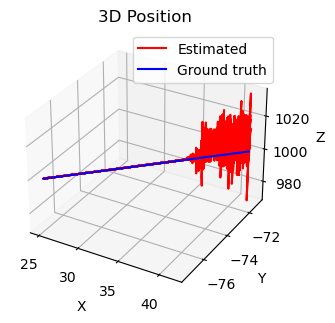

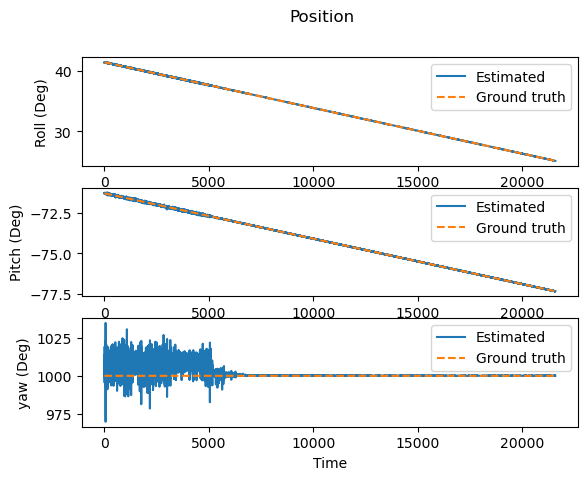

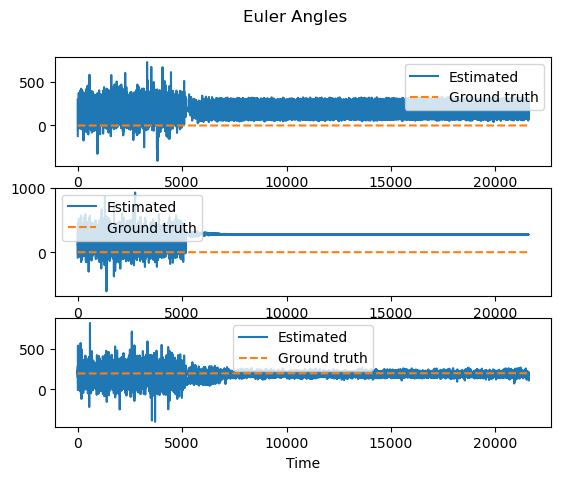

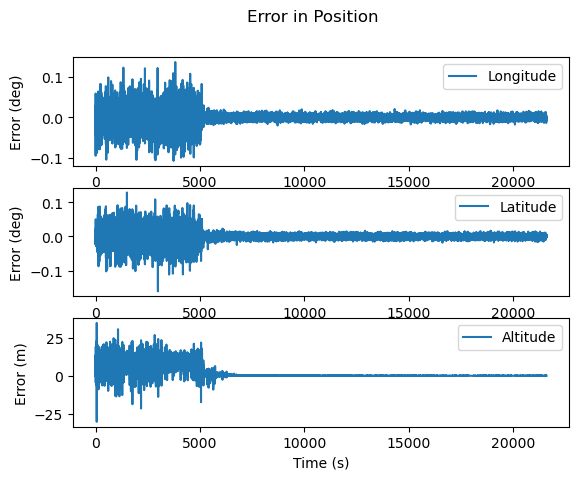

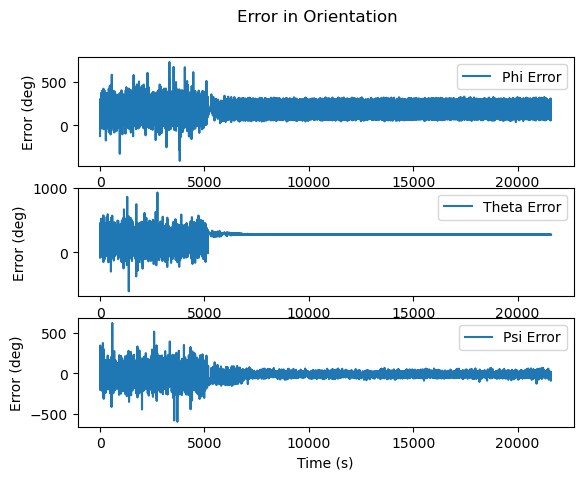

Average error in Longitude (deg):, 0.008136361036566788
Average error in Latitude (deg):, 0.008093271132953179
Average error in Altutude (m):, 2.045658596359569
Average error in Roll (deg):, 178.8627502493486
Average error in Pitch (deg):, 256.5291429679588
Average error in Yaw (deg):, 38.728979233907


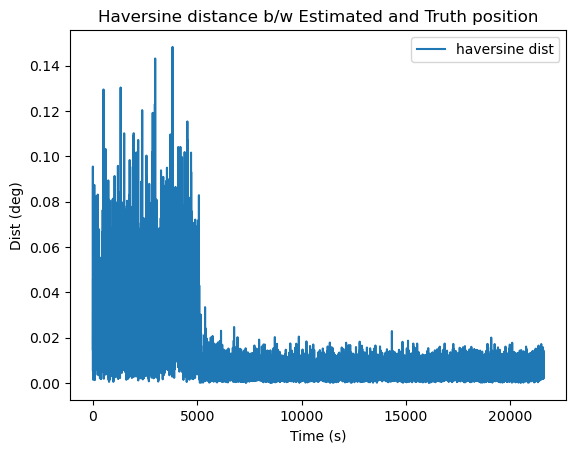

Average haversine dist (deg):  0.011507234682029962


In [4]:
from ins_gnss_fb import ins_gnss_fb
ins_gnss_fb()

From the above plots we can see that the position estimates are pretty accurate with an avg error in lat and long being 0.004 deg and altitude being 0.33 m. The initial fluctuations in height estimates that contribute largely to the error. However the orientation estimated are worse, with high fluctuations and high average error. The average haversine distance - 0.0077 deg, with a maximum distance of 0.14 deg, tells us that the positions estimates are very close to the ground truth values.

## Feedforward Model

The feedforward model results are shown below

100%|██████████| 21600/21600 [01:05<00:00, 329.12it/s]


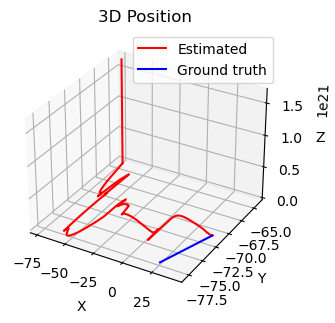

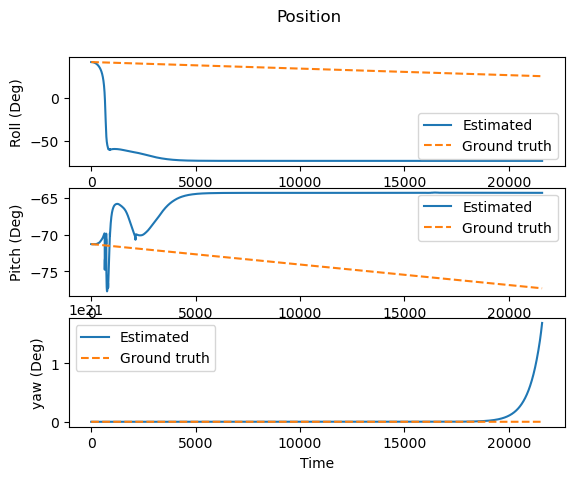

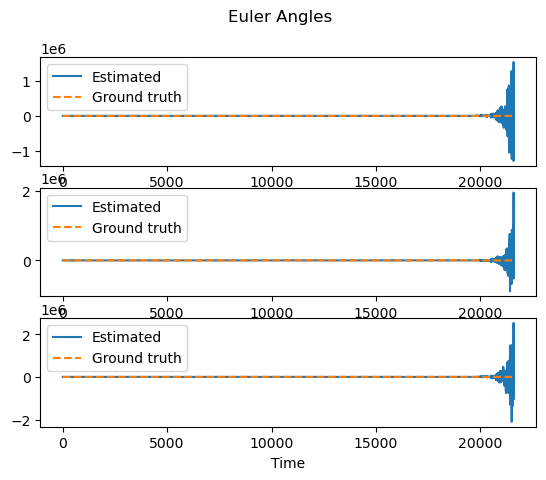

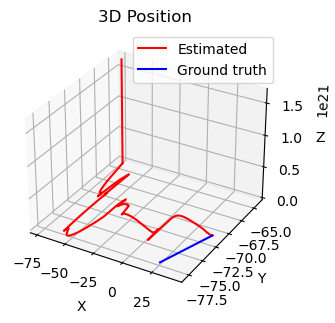

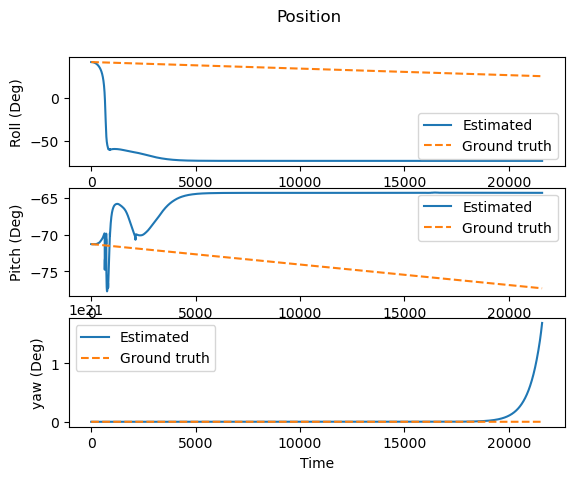

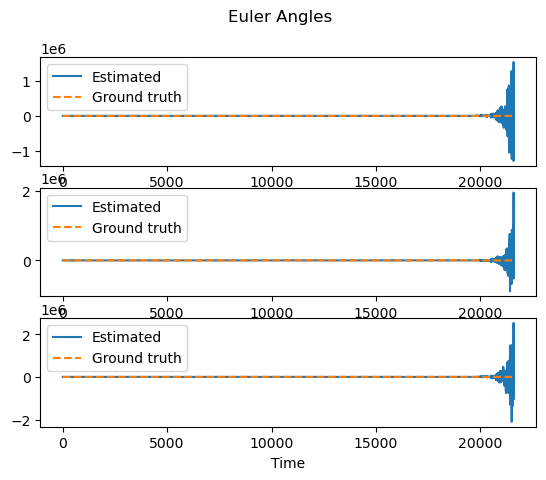

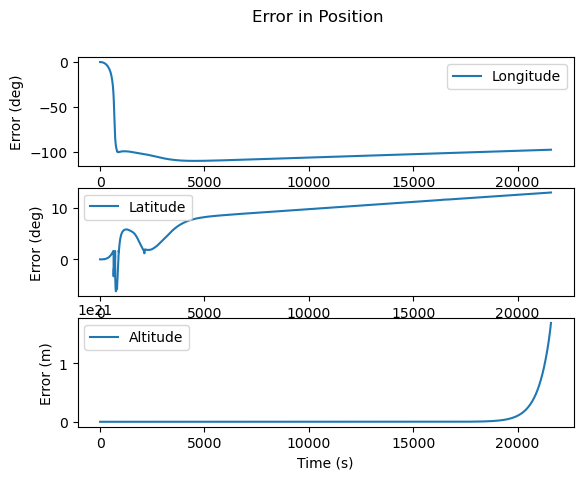

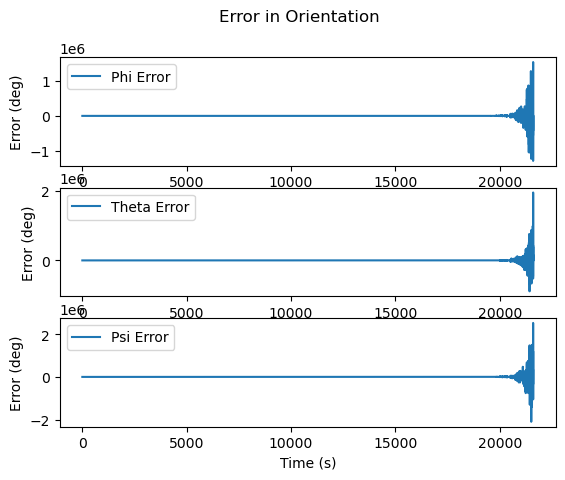

Average error in Longitude (deg):, 101.49168588594819
Average error in Latitude (deg):, 9.256913720358513
Average error in Altutude (m):, 4.437809543771459e+19
Average error in Roll (deg):, 5126.410599528843
Average error in Pitch (deg):, 3807.7387315680025
Average error in Yaw (deg):, 5841.642376666356


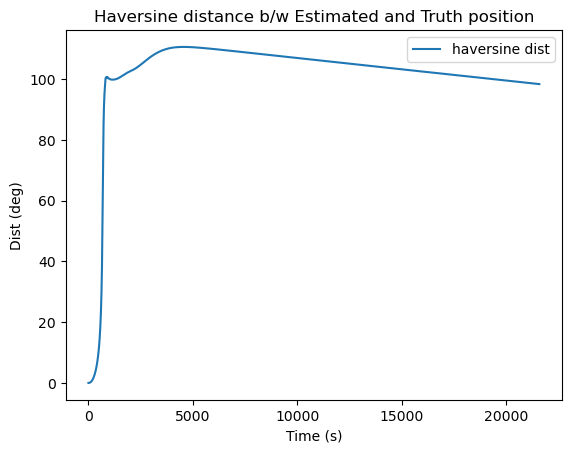

Average haversine dist (deg):  101.71060846628744


In [3]:
from ins_gnss_ff import ins_gnss_ff

ins_gnss_ff()

The above plots show that the feedforward model results are very bad and way off from the groundtruth values. The altitude estimate seems to be close to the truth values in the beginning, however it fluctuates and explode at the end. The latitude and longitude estimates are far off the truth since the beginning. The orientation estimates are also close to the truth values but blow up at the end with errors climbing over 5000. The haversine distance plot shows that the postions estimates are bad with an avg dist of 101.7 deg and max value of around ~110 deg.

**Feedback vs feedforawrd model**

1. From the above results it is clear that the feedback model performs better than the feedforward model with very accurate position estimates. 
2. The feedback model was easy to implement and tune. Whereas, the feedforward model was very hard to tune - the filter needed extremely high error state covariaces to be able to process the whole dataset and produce estimates.
3. The estimates obtained from the feedforward model are inaccurate and the states tend to explode at the end.

From the above discussion we can conclude that **the feedback model is better than the feedforward model**. 

**Haversine Distance**

The haversine distance might not be a good error metric since it only calculates the straight line distance between two local co-rodinates (lat and long). It does not take into account the altitude of the system, so basically the system can have zero haversine distance but still have a large error in altitude and be way off from gorund truth position. In addition, using haversine we cannot compare the orientation estimates of the system. Other metrics such as great-circle distance, geodesic distance, or more sophisticated error measures that incorporate both position and orientation errors can be used to get a fair comparition of the complete pose of the system.